## Towards the comparison of the signal-to-noise achieved with different filter widths

## Signal-to-noise calculations

As a function of exposure time, what is the signal-to-noise for the different filter widths?

How does that change when the CWL of the filters changes?

What is the benefit of the narrow bandwidth filters over larger bandwidth?


### Some background

The SNR is calculated following the equation (see, e.g., pg 407 of "Spectroscopic Instrumentation" by Eversberg and Vollmann): 

$SNR = \frac{I t}{\sqrt{I t + B t + D t + R^2}}$, 

where I is the signal over some number of pixels, B is the sky background over some number of pixels, D is the dark current over some number of pixels and R is the readout noise of the detector.  The exposure time, t, is usually given in seconds.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as const
from astropy import units as u
from astropy.io import fits
import math

In [2]:
class DragonflySystem(object):

    """This class represented the noise calculations 
    for the Dragonfly Array."""

    def __init__(self, number_of_lenses = 48.,oldcam=False):
        self.number_of_lenses = number_of_lenses
        self.area_lens = self.calculate_lens_area()
        self.tau_l = 0.85  # transmittance of the Dragonfly lens
        self.tau_f = 1.    # transmittance of the Halpha filter -- assumed for now
        if oldcam:
            self.QE = 0.48 * u.electron / u.photon
            self.ro_noise = 10.  # read noise (electrons)
            self.dark_curr = 0.02 *u.photon/u.second    # dark current (electrons / s / pix)
            self.pix_size = 2.8 # arcsec / pix
        else:
            self.QE = 0.75 * u.electron / u.photon
            self.ro_noise = 4.5  # read noise (electrons)
            self.dark_curr = 0.025 *u.electron/u.second    # dark current (electrons / s / pix)
            self.pix_size = 2.45 # arcsec / pix

        self.ang_pix_size = (self.pix_size * (1./206265.))**2 * u.rad**2
        self.ro_squared = self.ro_noise**2 * u.electron

    def calculate_lens_area(self):
        return np.pi*(14.3/2)**2 * self.number_of_lenses * u.cm**2
    
    def report(self):
        print('Number of lenses (lens area): %s (%s)'%\
              (self.number_of_lenses,self.area_lens))
        print('Quantum Efficiency: %s'%self.QE)
        print('Readout Noise (RO squared): %s (%s)'%\
              (self.ro_noise,self.ro_squared))
        print('Dark Current: %s'%self.dark_curr)
        print('Pixel Size: %s'%self.pix_size)

    
def calculate_signal_to_noise(SB_ph,B,time,explength=30.*(60.*u.second)):
    numexp=1
    if isinstance(time.value, (np.ndarray)):
        numexp = np.array([math.ceil(thistime/explength) for thistime in time])
    else:
        numexp = math.ceil(time/explength) # round up the number of exposures
        
    S = SB_ph * QE * tau_l * tau_f * area_lens * ang_size_pixel
    signal = S*time*numpixel
    B_tot = B * QE * tau_l * tau_f * area_lens.to(u.m**2) * ang_size_pixel.to(u.arcsec**2)
    print('total S: %s'%signal)
    print('total B: %s'%(B_tot*time*numpixel))
    #sigma = np.sqrt(signal + B_tot*time*numpixel + D*time*numpixel + R_squared*numpixel)
    sigma = np.sqrt(signal + B_tot*time*numpixel + D*time*numpixel*numlens + 
                    R_squared*numpixel*numlens*numexp)
    print ('total R: %s'%(R_squared*numpixel*numlens*numexp))
    SNR = signal/sigma
    return SNR


#### from SkyBackground_FilterWidthComparison:

In [3]:
B_10nm_G_1  = 4.91488*u.photon/u.second/u.arcsec**2/u.m**2  # already times the filter width
B_3nm_G_1  = 1.52495*u.photon/u.second/u.arcsec**2/u.m**2  # already times the filter width
B_08nm_G_1 = 0.383995*u.photon/u.second/u.arcsec**2/u.m**2  # already times the filter width

#### compare noise as a function of exposure time

In [4]:
numlens = 1.
numexp = 1.
numpixel = 1.

noise = DragonflySystem(number_of_lenses=numlens)
noise.report()

Number of lenses (lens area): 1.0 (160.6060704331442 cm2)
Quantum Efficiency: 0.75 electron / ph
Readout Noise (RO squared): 4.5 (20.25 electron)
Dark Current: 0.025 electron / s
Pixel Size: 2.45


168.69476578200826 electron
12.988254916731819 electron(1/2)


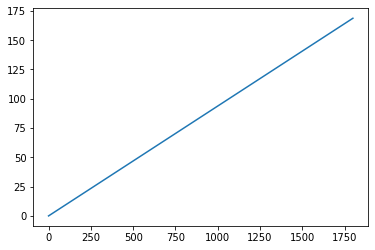

In [7]:
exposure_length = 1800. * u.second * numexp
time = np.arange(exposure_length.value)

factor_perpixel = noise.QE * noise.tau_l * noise.tau_f * \
    noise.area_lens.to(u.m**2) * noise.ang_pix_size.to(u.arcsec**2)

B_noise = B_3nm_G_1 * factor_perpixel * numpixel

plt.plot(time,B_noise*time*u.second)

print(B_noise*exposure_length)

print(np.sqrt(B_noise*exposure_length))


In [54]:
R_noise = noise.ro_squared*numlens*numexp

print(R_noise)

20.25 electron


In [6]:
D_noise = noise.dark_curr * numlens * exposure_length * numpixel

print(D_noise)
print(np.sqrt(D_noise))

45.0 electron
6.708203932499369 electron(1/2)
